# Template Live data

### Import Library

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import requests
import os
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

import warnings
warnings.filterwarnings('ignore')

In [46]:
USER_AGENTS = [
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.41 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 12_3_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.41 Safari/537.36",
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.41 Safari/537.36"
]

HEADERS = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
VNDIRECT_DATA_HISTORY_URL = 'https://dchart-api.vndirect.com.vn/dchart/history'
URL = VNDIRECT_DATA_HISTORY_URL

In [47]:
def getStockHistoryData(ticker, timestamp_from=0, timestamp_to=0):
    if timestamp_from == 0:
        three_months = date.today() + relativedelta(months=-3)
        timestamp_from = datetime.strptime(three_months.strftime("%m/%d/%Y") + ', 00:00:0', "%m/%d/%Y, %H:%M:%S")\
            .timestamp()
    if timestamp_to == 0:
        timestamp_to = datetime.strptime(date.today().strftime("%m/%d/%Y") + ', 23:59:00', "%m/%d/%Y, %H:%M:%S")\
            .timestamp()

    params = {
        "resolution": "5",
        "symbol": str(ticker),
        "from": int(timestamp_from),
        "to": int(timestamp_to)
    }

    x = requests.get(URL, params=params, headers=HEADERS)
    response = x.json()

    import numpy as np
    import pandas as pd

    timestamp = np.array(response['t']).astype(int)
    close = np.array(response['c']).astype(float)
    open = np.array(response['o']).astype(float)
    high = np.array(response['h']).astype(float)
    low = np.array(response['l']).astype(float)
    volume = np.array(response['v']).astype(int)

    dataset = pd.DataFrame({'Time': timestamp, 'Open': list(open), 'High': list(high), 'Low': list(low),
                            'Close': list(close), 'Volume': list(volume)},
                           columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
    return dataset

In [48]:
def prepareData(htd):
    if 'Time' in htd.columns:
        from datetime import datetime

        htd['DateStr'] = htd.apply(
            lambda x: datetime.fromtimestamp(x['Time']).strftime("%Y-%m-%d %H:%M:%S"), axis=1)

    htd['Date'] = pd.to_datetime(htd['DateStr'])
    ticker_data = htd.set_index('Date')
    ticker_data.drop(columns=['Time', 'DateStr'], inplace=True)
    return ticker_data

### Load Price Data

In [49]:
ticker = "VN30F1M"
htd = getStockHistoryData(ticker, 0, 0)
ticker_data = prepareData(htd)
ticker_data = ticker_data.dropna()
ticker_data

,Open,High,Low,Close,Volume
Date,,,,,
2024-08-01 09:00:00,1305.5,1306.0,1305.2,1305.5,6035
2024-08-01 09:05:00,1305.3,1306.2,1305.3,1306.1,2761
2024-08-01 09:10:00,1306.1,1306.1,1305.6,1306.0,1570
2024-08-01 09:15:00,1306.0,1306.2,1304.8,1306.0,2883
2024-08-01 09:20:00,1306.0,1306.1,1304.3,1304.8,2788
...,...,...,...,...,...
2024-11-01 09:15:00,1337.5,1338.0,1337.1,1337.7,2665
2024-11-01 09:20:00,1337.7,1338.8,1337.4,1338.6,3173
2024-11-01 09:25:00,1338.5,1338.6,1337.9,1338.1,1973


In [50]:
def bar9h(tick):
    tick = tick[(tick.index.hour == 9) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]


def bar14h25(tick):
    tick = tick[(tick.index.hour == 14) & (tick.index.minute == 25)]
    if len(tick):
        return tick[0]


def prepare_data(data):
    data['Close_9h'] = data['Close']
    data['exit_price'] = data['Close']
    day_data = data.resample('D').agg({
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min',
        'Close_9h': bar9h,
        'exit_price': bar14h25
    })
    day_data.dropna(subset=['Close'], inplace=True)
    #
    day_data['fibo_0'] = day_data['Low'].shift(1)
    day_data['fibo_0_rate_x'] = 100 * (day_data.fibo_0 - day_data.Close.shift(1)) / day_data.Close.shift(1)
    day_data['fibo_0_rate_y'] = (day_data.fibo_0 - day_data.Close_9h) / (
                day_data.High.shift(1) - day_data.Low.shift(1))
    #
    day_data['fibo_236'] = day_data['Low'].shift(1) + 0.236 * (day_data['High'].shift(1) - day_data['Low'].shift(1))
    day_data['fibo_236_rate_x'] = 100 * (day_data.fibo_236 - day_data.Close.shift(1)) / day_data.Close.shift(1)
    day_data['fibo_236_rate_y'] = (day_data.fibo_236 - day_data.Close_9h) / (
                day_data.High.shift(1) - day_data.Low.shift(1))
    #
    day_data['fibo_382'] = day_data['Low'].shift(1) + 0.382 * (day_data['High'].shift(1) - day_data['Low'].shift(1))
    day_data['fibo_382_rate_x'] = 100 * (day_data.fibo_382 - day_data.Close.shift(1)) / day_data.Close.shift(1)
    day_data['fibo_382_rate_y'] = (day_data.fibo_382 - day_data.Close_9h) / (
                day_data.High.shift(1) - day_data.Low.shift(1))
    #
    day_data['fibo_5'] = day_data['Low'].shift(1) + 0.5 * (day_data['High'].shift(1) - day_data['Low'].shift(1))
    day_data['fibo_5_rate_x'] = 100 * (day_data.fibo_5 - day_data.Close.shift(1)) / day_data.Close.shift(1)
    day_data['fibo_5_rate_y'] = (day_data.fibo_5 - day_data.Close_9h) / (
                day_data.High.shift(1) - day_data.Low.shift(1))
    #
    day_data['fibo_618'] = day_data['Low'].shift(1) + 0.618 * (day_data['High'].shift(1) - day_data['Low'].shift(1))
    day_data['fibo_618_rate_x'] = 100 * (day_data.fibo_618 - day_data.Close.shift(1)) / day_data.Close.shift(1)
    day_data['fibo_618_rate_y'] = (day_data.fibo_618 - day_data.Close_9h) / (
                day_data.High.shift(1) - day_data.Low.shift(1))
    #
    day_data['fibo_786'] = day_data['Low'].shift(1) + 0.786 * (day_data['High'].shift(1) - day_data['Low'].shift(1))
    day_data['fibo_786_rate_x'] = 100 * (day_data.fibo_786 - day_data.Close.shift(1)) / day_data.Close.shift(1)
    day_data['fibo_786_rate_y'] = (day_data.fibo_786 - day_data.Close_9h) / (
                day_data.High.shift(1) - day_data.Low.shift(1))
    #
    day_data['fibo_1'] = day_data['Low'].shift(1) + 1 * (day_data['High'].shift(1) - day_data['Low'].shift(1))
    day_data['fibo_1_rate_x'] = 100 * (day_data.fibo_1 - day_data.Close.shift(1)) / day_data.Close.shift(1)
    day_data['fibo_1_rate_y'] = (day_data.fibo_1 - day_data.Close_9h) / (
                day_data.High.shift(1) - day_data.Low.shift(1))
    #
    day_data['fibo_0_return'] = 1000 * (day_data.exit_price - day_data.fibo_0) / day_data.fibo_0
    day_data['fibo_236_return'] = 1000 * (day_data.exit_price - day_data.fibo_236) / day_data.fibo_236
    day_data['fibo_382_return'] = 1000 * (day_data.exit_price - day_data.fibo_382) / day_data.fibo_382
    day_data['fibo_5_return'] = 1000 * (day_data.exit_price - day_data.fibo_5) / day_data.fibo_5
    day_data['fibo_618_return'] = 1000 * (day_data.exit_price - day_data.fibo_618) / day_data.fibo_618
    day_data['fibo_786_return'] = 1000 * (day_data.exit_price - day_data.fibo_786) / day_data.fibo_786
    day_data['fibo_1_return'] = 1000 * (day_data.exit_price - day_data.fibo_1) / day_data.fibo_1
    #
    day_data['fibo_0_risk_reward'] = (day_data.High - day_data.fibo_0) - (day_data.fibo_0 - day_data.Low)
    day_data['fibo_236_risk_reward'] = (day_data.High - day_data.fibo_236) - (day_data.fibo_236 - day_data.Low)
    return day_data

In [51]:
day_data = prepare_data(ticker_data)

In [52]:
day_data

,Open,Close,High,Low,Close_9h,exit_price,fibo_0,fibo_0_rate_x,fibo_0_rate_y,fibo_236,...,fibo_1_rate_y,fibo_0_return,fibo_236_return,fibo_382_return,fibo_5_return,fibo_618_return,fibo_786_return,fibo_1_return,fibo_0_risk_reward,fibo_236_risk_reward
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-01,1305.5,1275.0,1306.2,1271.0,1305.5,1277.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-02,1266.2,1275.9,1277.5,1256.3,1264.6,1276.5,1271.0,-0.313725,0.181818,1279.3072,...,1.181818,4.327301,-2.194313,-6.186634,-9.390036,-12.572852,-17.069192,-22.737712,-8.2,-24.8144
2024-08-05,1256.8,1233.0,1262.8,1227.3,1253.1,1232.8,1256.3,-1.536171,0.150943,1261.3032,...,1.150943,-18.705723,-22.598214,-24.990857,-26.916094,-28.833743,-31.550951,-34.990215,-22.5,-32.5064
2024-08-06,1244.7,1249.6,1256.0,1237.2,1247.1,1252.8,1227.3,-0.462287,-0.557746,1235.6780,...,0.442254,20.777316,13.856361,9.621545,6.224650,2.850535,-1.914431,-7.918910,38.6,21.8440
2024-08-07,1252.3,1250.0,1255.5,1245.7,1251.5,1250.4,1237.2,-0.992318,-0.760638,1241.6368,...,0.239362,10.669253,7.057781,4.836459,3.048291,1.266477,-1.259448,-4.458599,26.8,17.9264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-28,1330.0,1332.0,1332.3,1327.2,1329.2,1331.1,1327.0,-0.015069,-0.171875,1330.0208,...,0.828125,3.089676,0.811416,-0.592842,-1.724914,-2.854424,-4.458137,-6.493506,5.5,-0.5416
2024-10-29,1334.0,1339.4,1341.0,1334.0,1335.4,1338.2,1327.2,-0.360360,-1.607843,1328.4036,...,-0.607843,8.288125,7.374566,6.810226,6.354578,5.899342,5.251919,4.428432,20.6,18.1928
2024-10-30,1341.6,1342.0,1342.7,1331.5,1340.9,1336.3,1334.0,-0.403166,-0.985714,1335.6520,...,0.014286,1.724138,0.485156,-0.279799,-0.897196,-1.513831,-2.390441,-3.504847,6.2,2.8960


In [53]:
last_data = day_data.iloc[-1]
last_data

Open                    1340.400000
Close                   1337.700000
High                    1340.400000
Low                     1336.900000
Close_9h                1337.800000
exit_price                      NaN
fibo_0                  1333.700000
fibo_0_rate_x             -0.729438
fibo_0_rate_y             -0.290780
fibo_236                1337.027600
fibo_236_rate_x           -0.481757
fibo_236_rate_y           -0.054780
fibo_382                1339.086200
fibo_382_rate_x           -0.328530
fibo_382_rate_y            0.091220
fibo_5                  1340.750000
fibo_5_rate_x             -0.204689
fibo_5_rate_y              0.209220
fibo_618                1342.413800
fibo_618_rate_x           -0.080849
fibo_618_rate_y            0.327220
fibo_786                1344.782600
fibo_786_rate_x            0.095467
fibo_786_rate_y            0.495220
fibo_1                  1347.800000
fibo_1_rate_x              0.320060
fibo_1_rate_y              0.709220
fibo_0_return               

In [54]:
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent.parent

In [55]:
def get_pivot_value_for_fibo(data, fibo_ret=0, type_info='mean_return'):
    db_dir = str(algo_dir) + '/VN30ps/fibonacci/'
    fibo_db_file = str(db_dir) + '/fibo_' + str(fibo_ret) + '_' + type_info + '_db.pkl'
    is_file = os.path.isfile(fibo_db_file)
    if is_file:
        with open(fibo_db_file, 'rb') as f:
            pivot_df = pickle.load(f)
            found_i = None
            for i in pivot_df.index:
                fibo_rate_x = f'fibo_{fibo_ret}_rate_x'
                if i.left < data[fibo_rate_x] <= i.right:
                    found_i = i
                    break
            found_c = None
            for c in pivot_df.columns:
                fibo_rate_y = f'fibo_{fibo_ret}_rate_y'
                if c.left < data[fibo_rate_y] <= c.right:
                    found_c = c
                    break
            found = pivot_df.loc[pivot_df.index == found_i, found_c]
            if len(found):
                val = found.values[0]
                return val
    return 0

In [56]:
#
_9h_price = last_data['Close_9h']
fibonacci = [0, 236, 382, 5, 618, 786, 1]
msg = ''
above_price_msg = f'Above current price({_9h_price}): \n'
below_price_msg = f'Below current price({_9h_price}): \n'
has_up_fibo = False
has_down_fibo = False
mean_return_compare = 3
for fibo in fibonacci:
    fibo_text = f"Fibo(0.{fibo})" if fibo != 1 else f"Fibo({fibo})"
    col = f"fibo_{fibo}"
    if last_data[col] > _9h_price:
        has_up_fibo = True
        fibo_up_mean_return = get_pivot_value_for_fibo(last_data, fibo)
        fibo_up_risk_reward = get_pivot_value_for_fibo(last_data, fibo, 'risk_reward')
        signal_text = "Long" if fibo_up_mean_return > mean_return_compare else(
            "Short" if fibo_up_mean_return < -mean_return_compare else "None")
        above_price_msg += f'{fibo_text} - {last_data[col]} \n ' \
                           f'Mean return: {fibo_up_mean_return} \n ' \
                           f'Risk-Reward: {fibo_up_risk_reward} \n ' \
                           f'Signal: {signal_text} ({last_data[col]}) \n'
    elif last_data[col] < _9h_price:
        continue

res_fibonacci = fibonacci[::-1]
for fibo in res_fibonacci:
    fibo_text = f"Fibo(0.{fibo})" if fibo != 1 else f"Fibo({fibo})"
    col = f"fibo_{fibo}"
    if last_data[col] > _9h_price:
        continue
    else:
        has_down_fibo = True
        fibo_down_mean_return = get_pivot_value_for_fibo(last_data, fibo)
        fibo_down_risk_reward = get_pivot_value_for_fibo(last_data, fibo, 'risk_reward')
        signal_text = "Long" if fibo_down_mean_return > mean_return_compare else (
            "Short" if fibo_down_mean_return < -mean_return_compare else "None")
        below_price_msg += f'{fibo_text} - {last_data[col]} \n ' \
                           f'Mean return: {fibo_down_mean_return} \n ' \
                           f'Risk-Reward: {fibo_down_risk_reward} \n ' \
                           f'Signal: {signal_text}({last_data[col]}) \n'

if has_up_fibo:
    msg += above_price_msg
if has_up_fibo and has_down_fibo:
    msg += "\n -------------------- \n"
if has_down_fibo:
    msg += below_price_msg

In [57]:
print(msg)

Above current price(1337.8): 
Fibo(0.382) - 1339.0862 
 Mean return: nan 
 Risk-Reward: nan 
 Signal: None (1339.0862) 
Fibo(0.5) - 1340.75 
 Mean return: nan 
 Risk-Reward: nan 
 Signal: None (1340.75) 
Fibo(0.618) - 1342.4138 
 Mean return: nan 
 Risk-Reward: nan 
 Signal: None (1342.4138) 
Fibo(0.786) - 1344.7826 
 Mean return: nan 
 Risk-Reward: nan 
 Signal: None (1344.7826) 
Fibo(1) - 1347.8 
 Mean return: nan 
 Risk-Reward: nan 
 Signal: None (1347.8) 

 -------------------- 
Below current price(1337.8): 
Fibo(0.236) - 1337.0276000000001 
 Mean return: 21.36508726814413 
 Risk-Reward: 30.25440000000026 
 Signal: Long(1337.0276000000001) 
Fibo(0.0) - 1333.7 
 Mean return: -0.4298576432320086 
 Risk-Reward: 12.319999999999983 
 Signal: None(1333.7) 



In [58]:
def show_pivots_table(fibo, type_info='mean_return'):
    db_dir = str(algo_dir) + '/VN30ps/fibonacci/'
    fibo_db_file = str(db_dir) + 'fibo_' + str(fibo) + '_' + type_info + '_db.pkl'
    is_file = os.path.isfile(fibo_db_file)
    if is_file:
        with open(fibo_db_file, 'rb') as f:
            stored_pivot_df = pickle.load(f)
            sns.heatmap(
            stored_pivot_df,
            cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
            annot=True, fmt=".1f");
    else:
        print(fibo_db_file)
        print('DB file not found.')

## Show pivots table for Fibo(0.0)

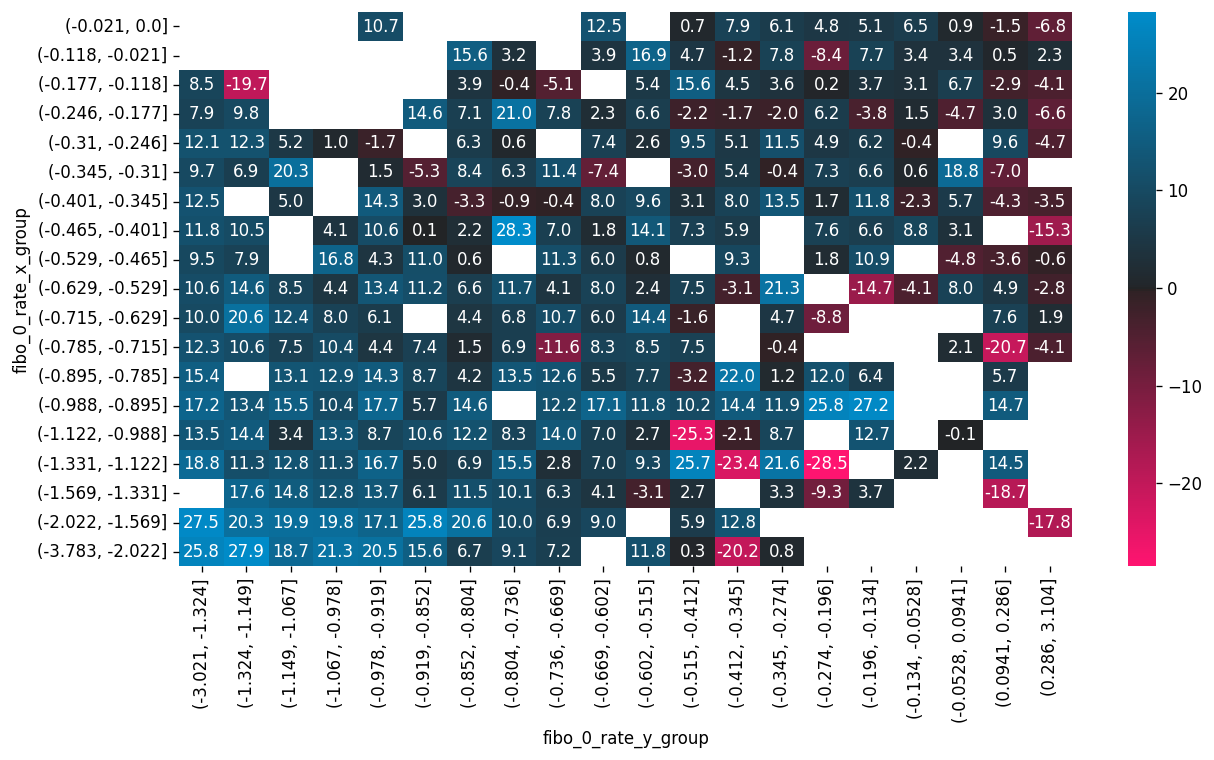

In [59]:
show_pivots_table(0)

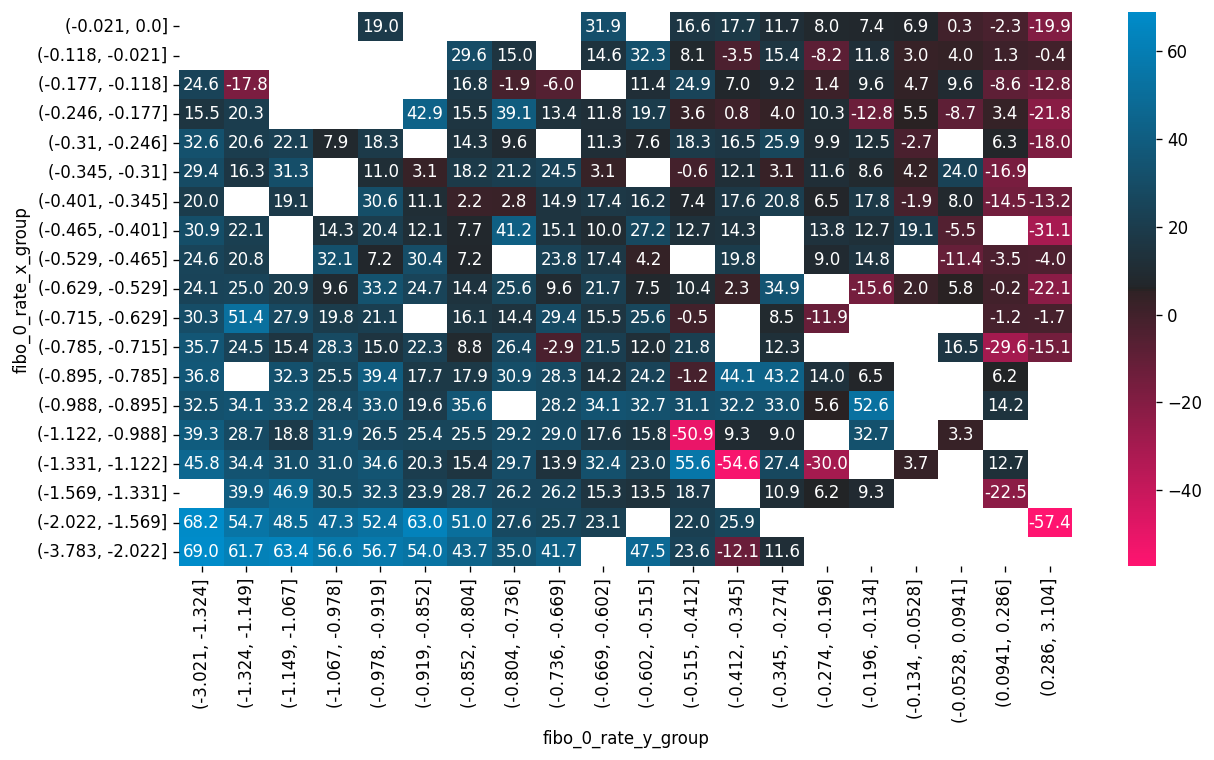

In [60]:
show_pivots_table(0, 'risk_reward')

## Show pivots table for Fibo(0.236)

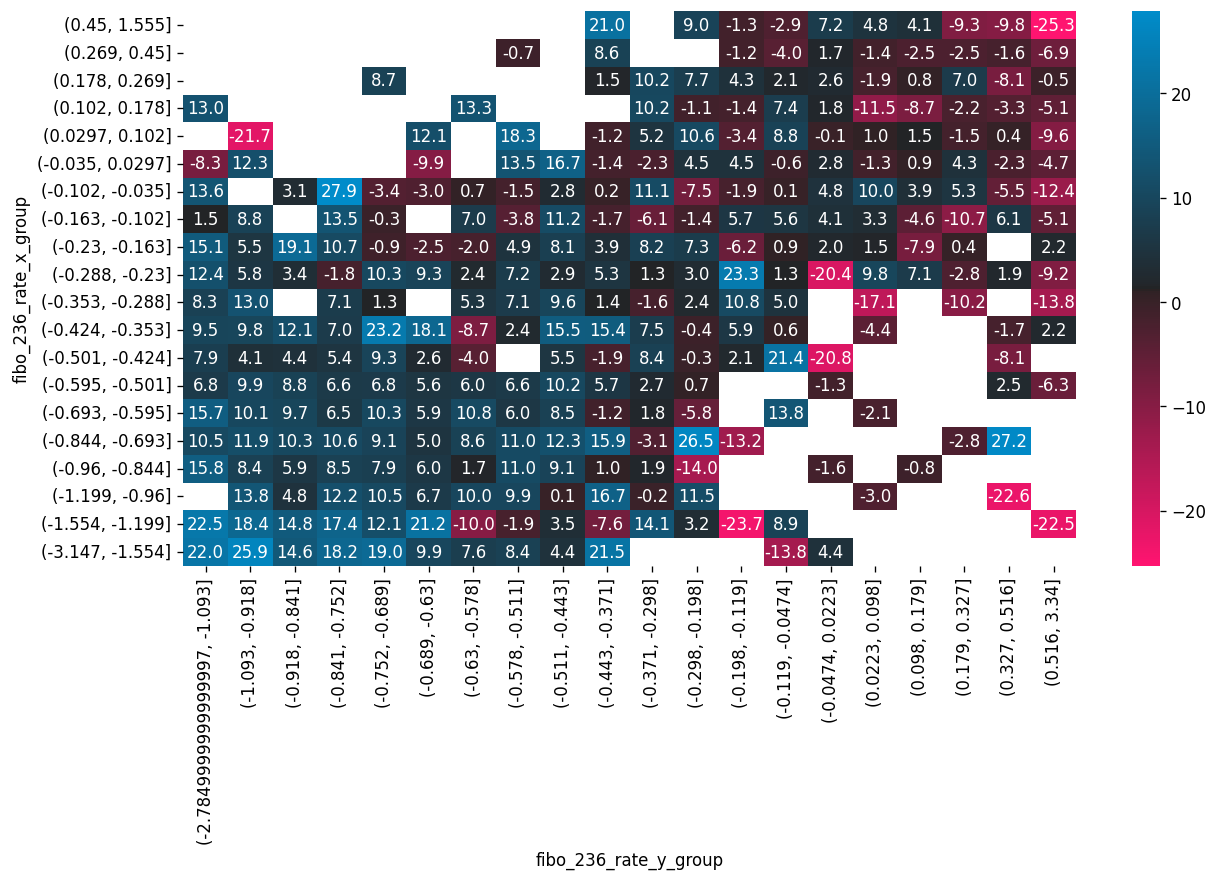

In [61]:
show_pivots_table(236)

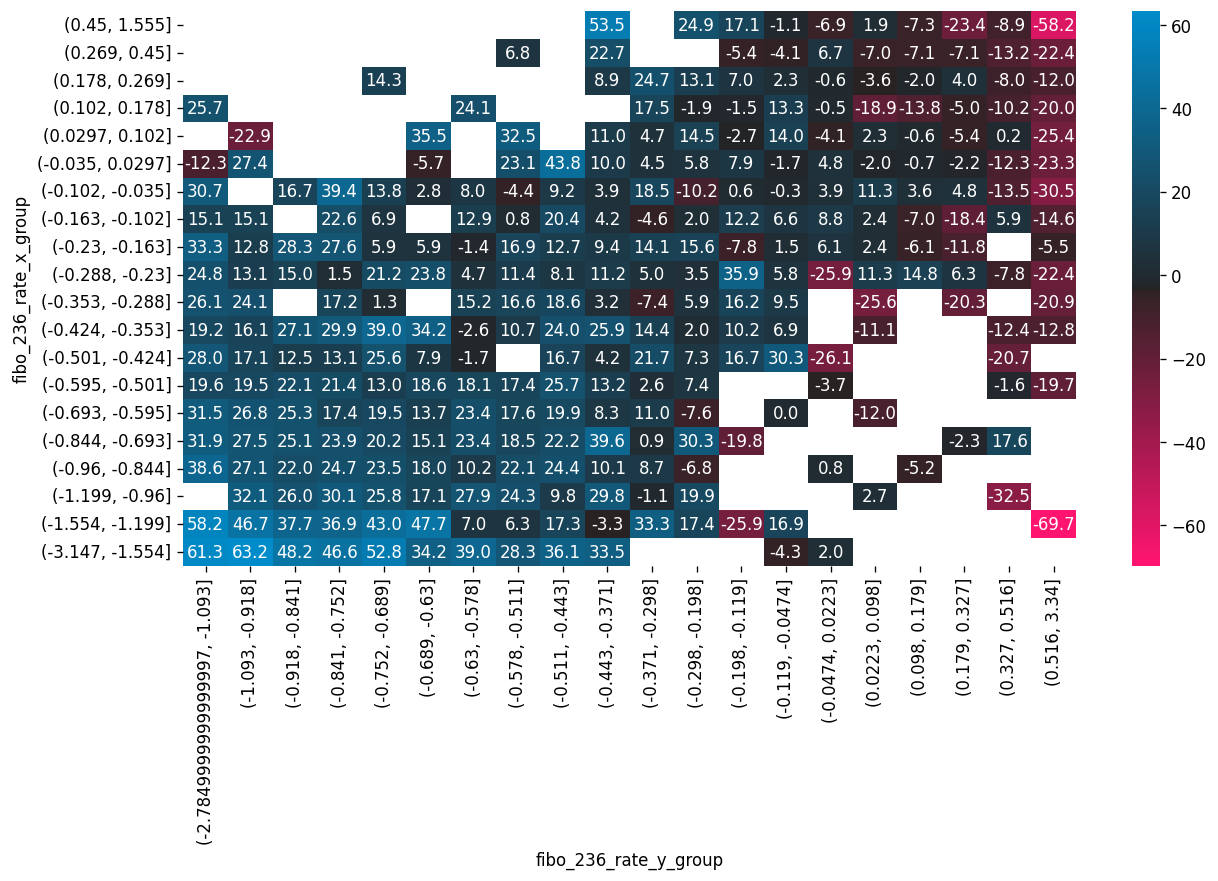

In [62]:
show_pivots_table(236, 'risk_reward')

## Show pivots table for Fibo(0.382)

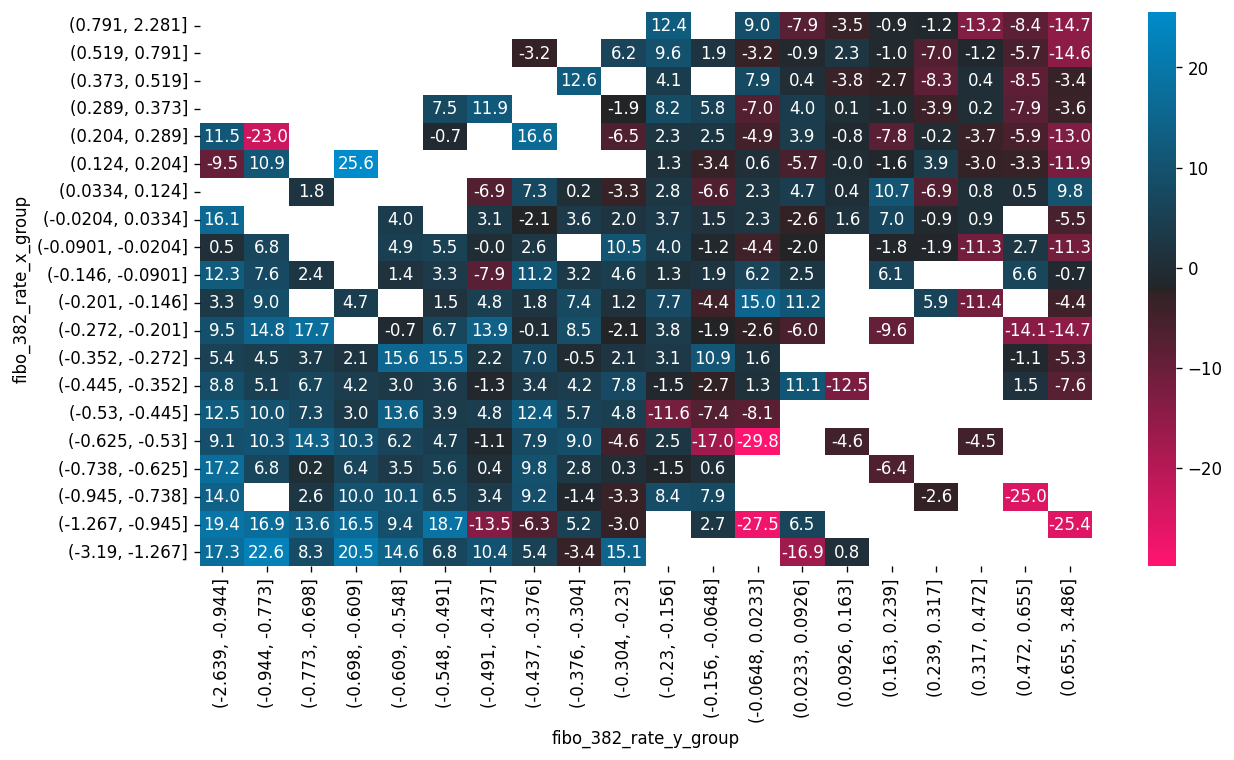

In [63]:
show_pivots_table(382)

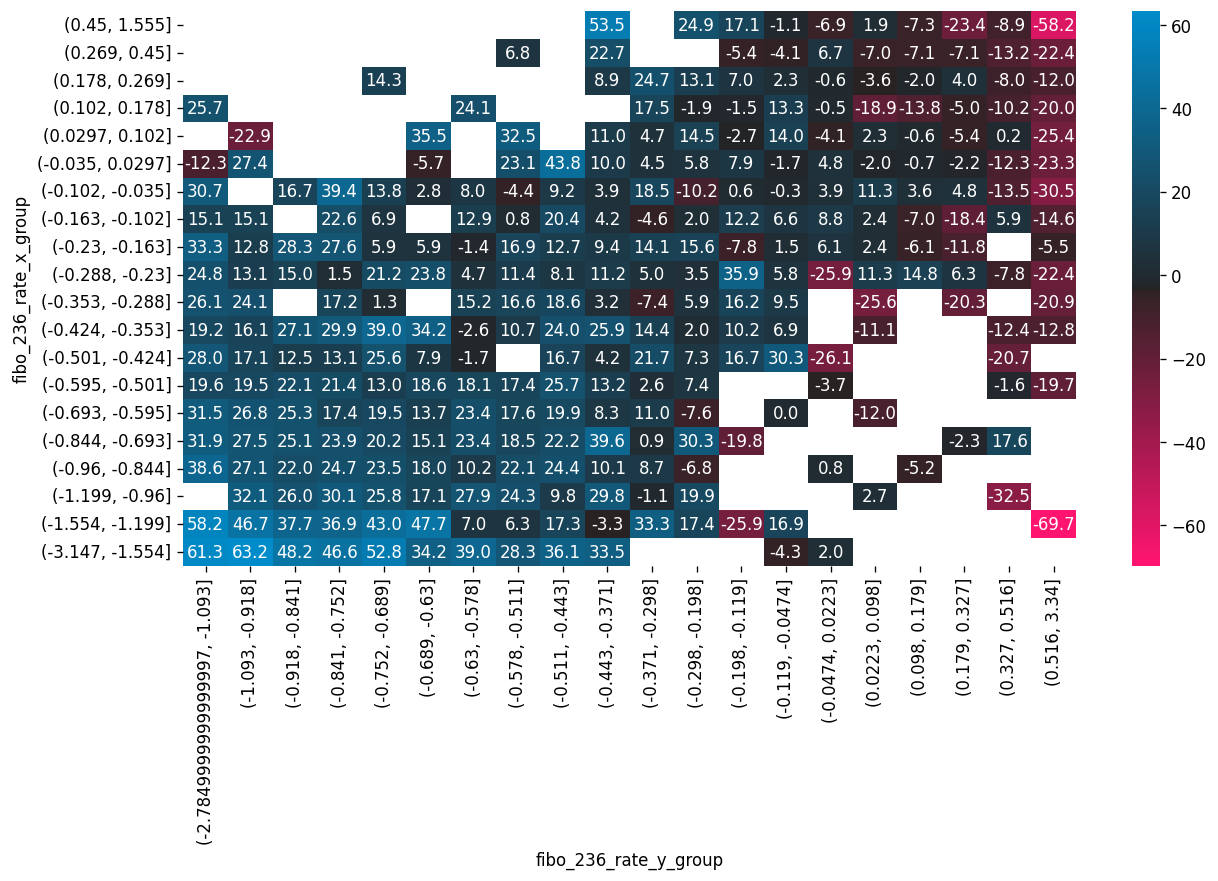

In [64]:
show_pivots_table(236, 'risk_reward')